# Exposure Time Predictor
Use observing conditions (sampled at earliest a few min ago, and many older points) to predict exposure time for next exposure at a new position, airmass, etc

### Features vs. Answers
 * Features: obsdb statistics since that's what see when observing
 * Answers: expfactor using depth in CP images as that's what actually wan to achieve, which is NOT expfactor column in the obsdb db! 

### Prediction
expfactor (exptime divided by a given band's nominal)

### Features

### Notes
 * supervised
 * online or batch?
 * regression classifier, model based
 * performance: RMSE
 * scaling of features: expfactor 
 * cleaning
  - transp > 0.9 for 50 consecutive exposures

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [4]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(7)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

%load_ext autoreload
%autoreload 2

REPO_DIR= os.path.join(os.environ['HOME'],
                       'PhdStudent/Research/desi/ml_data/')
DB_DIR= os.path.join(REPO_DIR,'obsbot/obsdb')

# Get the data

In [2]:
from exptime_predictor.data import Data,Clean

In [5]:
d= Data(REPO_DIR)
d.fetch_data()
df = d.load_data()

UNIX cmd: git pull origin master
Reading sqlite db: /Users/kaylan1/PhdStudent/Research/desi/ml_data/obsbot/obsdb/decam.sqlite3
Has tables:  [('django_migrations',), ('sqlite_sequence',), ('obsdb_measuredccd',)]
executing query: select * from obsdb_measuredccd


In [153]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21365 entries, 0 to 28832
Data columns (total 39 columns):
id              21365 non-null int64
filename        21365 non-null object
extension       21365 non-null object
expnum          21365 non-null int64
exptime         21365 non-null float64
mjd_obs         21365 non-null float64
airmass         21365 non-null float64
racenter        21365 non-null float64
deccenter       21365 non-null float64
rabore          21365 non-null float64
decbore         21365 non-null float64
band            21365 non-null object
ebv             21365 non-null float64
zeropoint       21365 non-null float64
transparency    21365 non-null float64
seeing          21365 non-null float64
sky             21365 non-null float64
expfactor       21365 non-null float64
camera          21365 non-null object
dx              21365 non-null float64
dy              21365 non-null float64
md5sum          21365 non-null object
bad_pixcnt      21365 non-null int64
readt

In [27]:
df.describe()

,id,expnum,exptime,mjd_obs,airmass,racenter,deccenter,rabore,decbore,ebv,...,tileebv,tileid,affine_dx,affine_dxx,affine_dxy,affine_dy,affine_dyx,affine_dyy,affine_x0,affine_y0
count,28833.000000,28833.000000,28833.000000,28833.000000,28833.000000,28833.000000,28833.000000,28833.000000,28833.000000,28833.000000,...,28833.000000,28833.000000,28833.000000,28833.000000,28833.000000,28833.000000,28833.000000,28833.000000,28833.000000,28833.000000
mean,14431.078625,560627.822530,87.433288,56853.854873,1.438167,151.523553,8.412245,193.183125,8.132037,0.036559,...,0.034614,15926.579579,-0.719712,0.707715,-0.000386,-6.631504,0.002075,0.708857,655.289009,1381.496653
std,8340.755394,114835.332314,62.757191,6604.921883,0.473826,115.715444,11.378085,96.327568,17.243986,0.036346,...,0.032069,15099.646869,1713.508761,2.484835,0.038888,1731.069609,2.178453,0.455108,419.630002,884.674450
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-31.008436,0.000000,-73.137498,0.000000,...,0.000000,0.000000,-125344.323834,-337.862078,-0.499329,-160443.912944,-191.342786,-4.137312,0.000000,0.000000
25%,7209.000000,511915.000000,40.000000,57403.308506,1.270000,0.000000,0.000000,142.263000,0.000000,0.000000,...,0.000000,0.000000,-0.046398,0.000000,-0.001169,-0.098892,0.000000,0.000000,0.000000,0.000000
50%,14417.000000,592890.000000,80.000000,57707.311814,1.550000,170.058443,5.482479,199.458000,10.374000,0.030791,...,0.030020,13908.000000,0.000000,1.000173,-0.000188,0.000000,0.000220,0.999986,924.000000,1948.000000
75%,21673.000000,647967.000000,125.000000,57886.831639,1.640000,230.267167,17.641923,250.345000,20.805305,0.051323,...,0.049628,29049.000000,0.059452,1.000386,0.000000,0.000000,0.001123,1.000122,924.000000,1948.000000
max,28881.000000,670845.000000,350.000000,57988.220115,2.520000,359.992843,34.745923,359.865825,34.821000,0.736545,...,0.261505,47616.000000,205151.430472,144.511725,6.489342,170406.659776,184.193757,1.019189,924.000000,1948.000000


In [36]:
#df.loc[:,'band'].values= np.char.strip(df.loc[:,'band'].values)
df.loc[:,'obstype'].value_counts()

object       21365
dome flat     2749
zero             2
Name: obstype, dtype: int64

In [38]:
bands= df.loc[:,'band']
df= df[(bands == 'g') |
       (bands == 'r') | 
       (bands == 'z') ]
df= df[(df.loc[:,'obstype'] == 'object')]
for key in ['band','obstype']:
    print(key.upper())
    print(df.loc[:,key].value_counts() ) 

BAND
z    9049
r    6168
g    6148
Name: band, dtype: int64
OBSTYPE
object    21365
Name: obstype, dtype: int64


# Add night_obs column
labels each exposure with the "observing night" it was taken on 

In [48]:
from astropy.time import Time

In [87]:
t = Time(df.loc[:,'mjd_obs'], format='mjd')
t.iso

array(['2016-02-25 05:11:31.769', '2016-02-25 05:16:21.401',
       '2016-02-25 05:09:01.413', ..., '2017-08-23 05:05:59.891',
       '2017-08-23 05:13:04.903', '2017-08-23 05:16:57.944'],
      dtype='<U23')

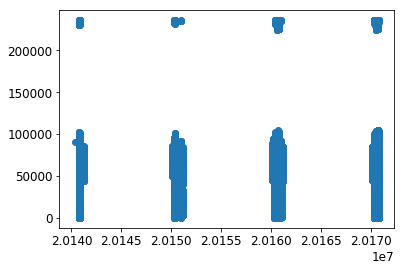

In [125]:
day_str= np.array([a.split(' ')[0] for a in t.iso])
hr_str= np.array([a.split(' ')[1] for a in t.iso])
day= np.char.replace(day_str,'-','').astype(int)
hr= np.char.replace(hr_str,':','').astype(float)
plt.scatter(day,hr)

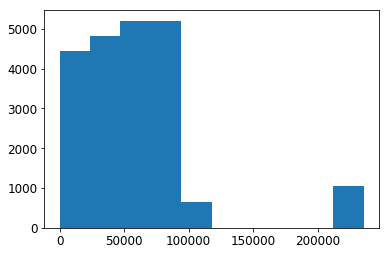

In [126]:
_=plt.hist(hr)

In [155]:
import time
from datetime import date, timedelta

def get_next_day(ymd):
    """given year month day string (ymd) return next calendar day
    
    Args:
        ymd: '20110531'
        
    Returns:
        ymd for next day: '20110601' for example above
    """
    t=time.strptime('20110531','%Y%m%d')
    newdate=date(t.tm_year,t.tm_mon,t.tm_mday)+timedelta(1)
    return newdate.strftime('%Y%m%d')

In [139]:
night_arr= np.zeros(len(df)).astype(np.int32) - 1

hr_thresh= 150000.
nights= np.sort( list(set(day)))
for night in nights:
    # night starts at nighttime
    first_half= (day == night) & (hr > hr_thresh)
    # night continues to morning of next day
    str_next_day= get_next_day(str(night))
    sec_half= (day == int(str_next_day) ) & (hr < hr_thresh)
    keep= first_half | sec_half
    if np.where(keep)[0].size > 0:
        night_arr[keep]= night

# add colm to df
df= df.assign(night_obs= night_arr)
        
    

In [154]:
df.loc[:,'night_obs'].value_counts()

-1           20317
 20160802       44
 20170504       31
 20170521       31
 20170721       31
 20160803       27
 20160608       27
 20170717       26
 20170718       25
 20160720       25
 20140816       25
 20140812       25
 20170520       24
 20140811       24
 20160812       23
 20170513       22
 20140810       22
 20150411       21
 20160723       21
 20160811       21
 20140818       21
 20140817       20
 20140815       20
 20160813       20
 20170519       20
 20170421       19
 20160409       18
 20170724       18
 20170729       18
 20150407       18
             ...  
 20170731       15
 20160410       14
 20160408       14
 20170726       14
 20150328       10
 20150408       10
 20170331        9
 20170329        9
 20150327        9
 20170326        9
 20150329        9
 20170503        9
 20170328        9
 20170819        8
 20170330        8
 20161011        6
 20151028        5
 20170315        5
 20170728        4
 20170327        4
 20140813        3
 20170730   